<div style="background-color: #0B132B; padding: 20px; border-radius: 10px; border: 3px solid #6FFFE9;">
    <br><br>
    <h1 style="color: #5BC0BE; text-align: center; font-size: 36px; margin-bottom: 15px;">NLP Disaster Tweets</h1><br>
    <h2 style="color: #4C698D; text-align: center; font-size: 26px; font-weight: bold; margin-top: 0;">Harman Singh</h2>
    <h2 style="color: #4C698D; text-align: center; font-size: 26px; font-weight: bold; margin-top: 0;">https://github.com/itsharman/NLP-Disaster-Tweets</h2>
<br><br><br>
</div>

In [204]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pickle

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2

import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

import seaborn as sns
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

# Set seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arnemartinfevolden/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/arnemartinfevolden/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<div style="background-color: #0B132B; padding: 25px; border-radius: 8px; border: 2px solid #6FFFE9; margin-top: 0;">
    <h3 style="color: #5BC0BE; text-align: center; font-size: 26px; margin-top: 30; margin-bottom: 30">Description of the Problem and Data</h3>
</div>

The main task in this competition is to create a machine learning model that can distinguish between tweets that are reporting disasters and those that are not. Individuals are often using Twitter (now X) to report emergencies in real time, making it a valuable resource for disaster relief and news agencies. However, to be able to use Twitter for emergancy warining, disaster relief organizations and news agencies need to be able to distinguis between tweets that report actual instead of metaphorical disasters. This can be difficult since the same words, such as 'ablaze' can have different meaning depending on the context. The aim in this assignment is to create a model that is able to make such distinctions.

<div style="background-color: #0B132B; padding: 25px; border-radius: 8px; border: 2px solid #6FFFE9; margin-top: 0;">
    <h3 style="color: #5BC0BE; text-align: center; font-size: 26px; margin-top: 30; margin-bottom: 30">Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data</h3>
</div>

In this section, we will ...
* provide a quantitative overview of the training and testing data.
* Verify that the data is sound and can be used in a Recurrent Neural Network (CNN) model
* Carry out text preprocessing and sequence preparation for model training

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Investigation</h3>
</div>

In [186]:
# Loading data
df_train = pd.read_csv('nlp-getting-started/train.csv')
df_test  = pd.read_csv('nlp-getting-started/test.csv')

In [187]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


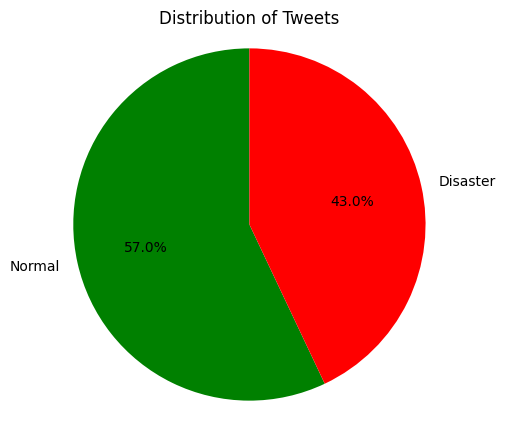

In [188]:
# Distribution of tweets
counts = df_train['target'].value_counts()
counts.index = ['Disaster' if i == 1 else 'Normal' for i in counts.index]

# Creating a pie chart
plt.figure(figsize=(5, 5))  # Set the size of the figure (optional)
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
plt.title('Distribution of Tweets')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

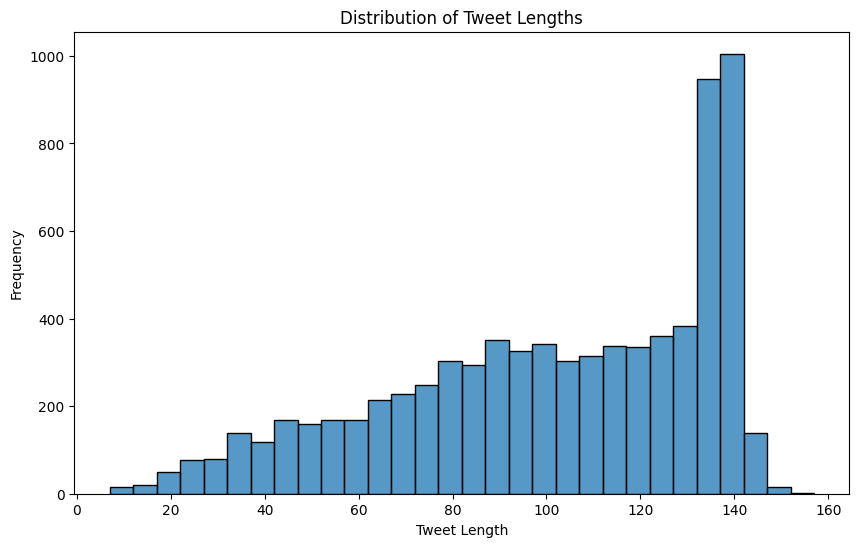

In [189]:
# Sample data loading
tweets = pd.read_csv('nlp-getting-started/train.csv')

# Basic statistics of tweet lengths
tweets['tweet_length'] = tweets['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(tweets['tweet_length'], bins=30, kde=False)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Text Preprocessing and Sequence Preparation for Model Training</h3>
</div>

In this part we will carry out a number of preprocessing steps, including:
* converting all tweets to lowercase
* remove all special characters
* remove stopwords
* lemmatize words (turn them into dictionary version)

In additon, we will look at the distribution of text length in terms of word count/tokens to find how much padding is needed in the RNN models.

In [190]:
# Initialize lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove all the special characters
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Replace multiple spaces with a single space
    # Lemmatization and stopword removal
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Apply cleaning function
df_train['cleaned_text'] = df_train['text'].apply(clean_text)

In [191]:
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(df_train['cleaned_text'], df_train['target'], test_size=0.2, random_state=42)

# Tokenizing text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)

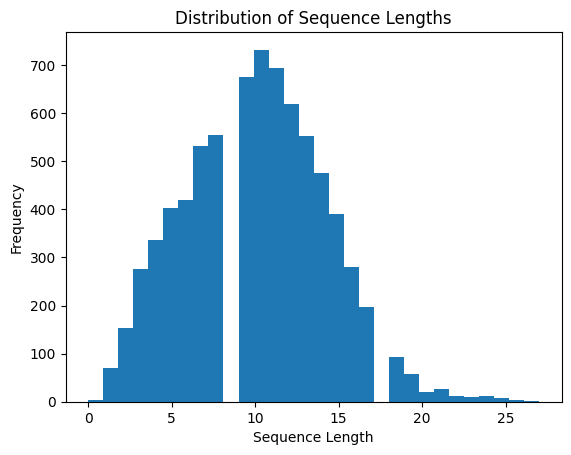

90th percentile: 15.0


In [192]:
# Analyzing the distribution of text lengths in terms of word count
sequence_lengths = [len(seq) for seq in tokenizer.texts_to_sequences(df_train['cleaned_text'])]

# Plotting the distribution
plt.hist(sequence_lengths, bins=30)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

# Determining a suitable `maxlen` based on percentile
import numpy as np
print("90th percentile:", np.percentile(sequence_lengths, 90))

In [193]:
# Padding sequences
X_train = pad_sequences(X_train, maxlen=15)
X_valid = pad_sequences(X_valid, maxlen=15)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Conclusion</h3>
</div>

Based on our investigations, we can conclude that:

* The dataset is balanced with about 43% real disaster tweets and 57% other tweets
* There is a large number of tweets that are 140 characters long, which for some time was the maximum allowed length. However, there are also a considerable number of tweets that are shorter.
* After we have removed stopwords and lemmatized the text, the most frequent tweets contain between 9-11 words (sequences)
* Since 90% of the tweets contained 15 or less words (sequences), we will set that as a maximum for our models.

All in all, this implies that there are good reasons to believe that the data should be suitable for an analysis using Ruccurrent Neural Networks.

<div style="background-color: #0B132B; padding: 25px; border-radius: 8px; border: 2px solid #6FFFE9; margin-top: 0;">
    <h3 style="color: #5BC0BE; text-align: center; font-size: 26px; margin-top: 30; margin-bottom: 30">Model Architecture</h3>
</div>

We will in this section will try out four different RNN architectures:

* **Vanilla (Basic) Architecture**
* **LSTM (Long Short-Term Memory) Architecture**
* **Bidirectional Architecture**
* **Deep (Stacked) Architecture**

The principle idea here is to see if we can improve the accuracy of our prediction by adopting specific architectural principles. Adding a LSTM layer to a RNN-model should help it improve accuracy by capturing long-term dependencies within sequential data. We will test this theory by adopting the LSTM Architecture. And bidirectional layers should allow the network to processing data from both past and future contexts simultaneously, which is very usefull for natural language processing. We will test that theory by adopting the Bidirectional Architecture. In both cases, we will compare these models with a model that applies a simpler and less sophisticated architecture, which is often referred to as the Vanilla Architecture. Finally, we will test a Deep model that add extra LSTM and dense layers. See illustration below.

In this section, we will exclusively focus on the architecture of the RNN and will not try to improve them using different optimizers or regularization techniques. We will do that in the next section after we have settled on a preferred architecture. 

![Example Image](images/architectures.png)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Useful functions and Constants</h3>
</div>

In [124]:
# Constants
max_words = 10000  # number of words to consider from the dataset
max_len   = 15  # sequences are padded/truncated to this length

In [84]:
def plot_training_history(history):
    # Get number of epochs
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot training & validation accuracy values
    plt.plot(epochs, history.history['accuracy'])
    plt.plot(epochs, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(epochs)  # Set x-ticks to be the epochs
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)  # Set x-ticks to be the epochs
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    

In [85]:
def get_best_epoch_stats(model_names, histories):
    accuracies = []
    losses = []
    
    for model_name, history in zip(model_names, histories):
        # Get the index of the epoch with the highest validation accuracy
        best_epoch_index = np.argmax(history.history['val_accuracy'])
        
        # Retrieve the accuracy and loss for the best epoch
        best_epoch_accuracy = history.history['val_accuracy'][best_epoch_index]
        best_epoch_loss = history.history['val_loss'][best_epoch_index]
        
        # Append the results to the respective lists
        accuracies.append(best_epoch_accuracy)
        losses.append(best_epoch_loss)
    
    return model_names, accuracies, losses
    

In [138]:
def plot_model_metrics(architectures, accuracies, losses):
    # Define colors
    accuracy_color = '#5BC0BE'
    loss_color = '#4C698D'

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Plot accuracy
    axs[0].bar(architectures, accuracies, color=accuracy_color)
    axs[0].set_title('Model Accuracy', fontsize=14)
    axs[0].set_ylabel('Accuracy', fontsize=12)
    axs[0].set_ylim([0, 1])

    # Adding the text labels on the bars
    for i in range(len(accuracies)):
        axs[0].text(i, accuracies[i] + 0.02, f'{accuracies[i]:.3f}', ha='center', va='bottom', color='black')

    # Plot loss
    axs[1].bar(architectures, losses, color=loss_color)
    axs[1].set_title('Model Loss', fontsize=14)
    axs[1].set_ylabel('Loss', fontsize=12)
    axs[1].set_ylim([0, max(losses)+0.1])

    # Adding the text labels on the bars
    for i in range(len(losses)):
        axs[1].text(i, losses[i] + 0.02, f'{losses[i]:.2f}', ha='center', va='bottom', color='black')  # white text for better visibility on dark color

    # Layout adjustments
    plt.tight_layout()

    # Display the plot
    plt.show()


<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Vanilla RNN Architecture</h3>
</div>

In [125]:
# Define the model
model_vanilla = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)), 
    SimpleRNN(64),  # Replacing LSTM with SimpleRNN
    Dense(1, activation='sigmoid')
])

# Create a new Adam optimizer instance for this specific model
custom_adam = Adam(learning_rate=0.0001)

# Compile the model
model_vanilla.compile(optimizer=custom_adam, loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=True)

# Train the model
history_vanilla = model_vanilla.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=128, callbacks=[early_stop])

# Evaluate the model on the validation set
loss, accuracy = model_vanilla.evaluate(X_valid, y_valid)
print()
print("Validation accuracy:", accuracy)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.5573 - loss: 0.6766 - val_accuracy: 0.6172 - val_loss: 0.6434
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.6685 - loss: 0.6272 - val_accuracy: 0.6625 - val_loss: 0.6220
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.7197 - loss: 0.5873 - val_accuracy: 0.7065 - val_loss: 0.5931
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.7889 - loss: 0.5186 - val_accuracy: 0.7695 - val_loss: 0.5196
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.8384 - loss: 0.4062 - val_accuracy: 0.7873 - val_loss: 0.4868
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.8683 - loss: 0.3231 - val_accuracy: 0.7820 - val_loss: 0.4831
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.8990 - loss: 0.2669 - val_accuracy: 0.7833 - val_loss: 0.4906
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.9179 - loss: 0.2303 - val_accuracy: 0.

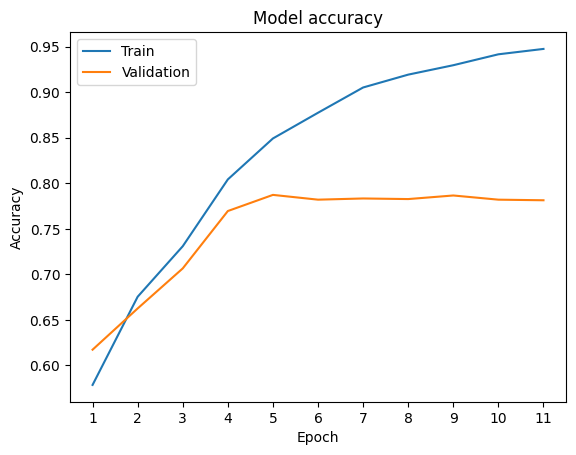

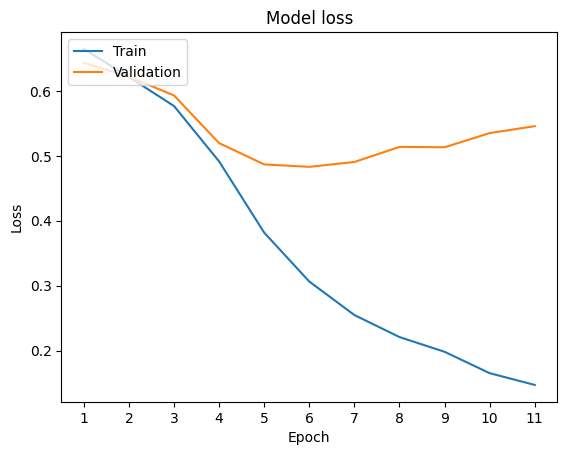

In [126]:
plot_training_history(history_vanilla)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">LSTM (Long Short-Term Memory) Architecture</h3>
</div>

In [127]:
model_LSTM = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)),
    LSTM(64),  # Single LSTM layer
    Dense(1, activation='sigmoid')
])

# Create a new Adam optimizer instance for this specific model
custom_adam = Adam(learning_rate=0.0001)

# Compile the model
model_LSTM.compile(optimizer=custom_adam, loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=True)

# Train the model
history_LSTM = model_LSTM.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=128, callbacks=[early_stop])

# Evaluate the model on the validation set
loss, accuracy = model_LSTM.evaluate(X_valid, y_valid)
print()
print("Validation accuracy:", accuracy)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5861 - loss: 0.6865 - val_accuracy: 0.5903 - val_loss: 0.6574
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6112 - loss: 0.6536 - val_accuracy: 0.6264 - val_loss: 0.6344
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6553 - loss: 0.6317 - val_accuracy: 0.6579 - val_loss: 0.6164
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6893 - loss: 0.6082 - val_accuracy: 0.6934 - val_loss: 0.5949
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7208 - loss: 0.5740 - val_accuracy: 0.7301 - val_loss: 0.5573
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7877 - loss: 0.5044 - val_accuracy: 0.7715 - val_loss: 0.4885
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8434 - loss: 0.3857 - val_accuracy: 0.7965 - val_loss: 0.4538
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8697 - loss: 0.3207 - val_accuracy: 0.8050 - v

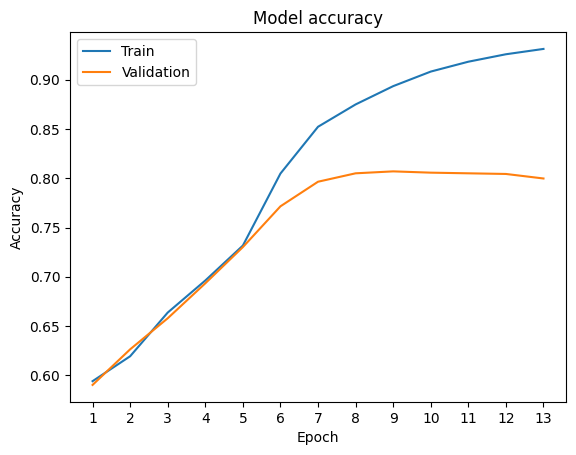

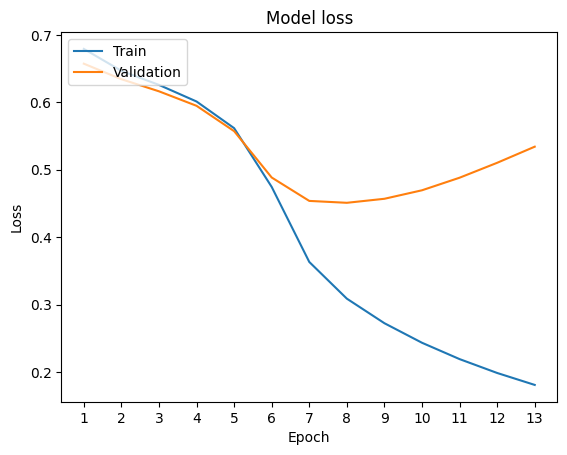

In [128]:
plot_training_history(history_LSTM)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Bidirectional LSTM RNN Architecture</h3>
</div>

In [129]:
# Model building
model_bidirect = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)),
    Bidirectional(LSTM(64)),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

# Create a new Adam optimizer instance for this specific model
custom_adam = Adam(learning_rate=0.0001)

# Compile the model
model_bidirect.compile(optimizer=custom_adam, loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=True)

# Train the model
history_bidirect = model_bidirect.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=128, callbacks=[early_stop])

# Evaluate the model on the validation set
loss, accuracy = model_bidirect.evaluate(X_valid, y_valid)
print()
print("Validation accuracy:", accuracy)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.5648 - loss: 0.6866 - val_accuracy: 0.5863 - val_loss: 0.6614
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5974 - loss: 0.6585 - val_accuracy: 0.6120 - val_loss: 0.6395
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6485 - loss: 0.6339 - val_accuracy: 0.6710 - val_loss: 0.6090
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7072 - loss: 0.5891 - val_accuracy: 0.7360 - val_loss: 0.5412
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8200 - loss: 0.4574 - val_accuracy: 0.7781 - val_loss: 0.5098
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8817 - loss: 0.3168 - val_accuracy: 0.7702 - val_loss: 0.5358
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9105 - loss: 0.2504 - val_accuracy: 0.7590 - val_loss: 0.5711
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9331 - loss: 0.2009 - val_accuracy: 0.7590 - v

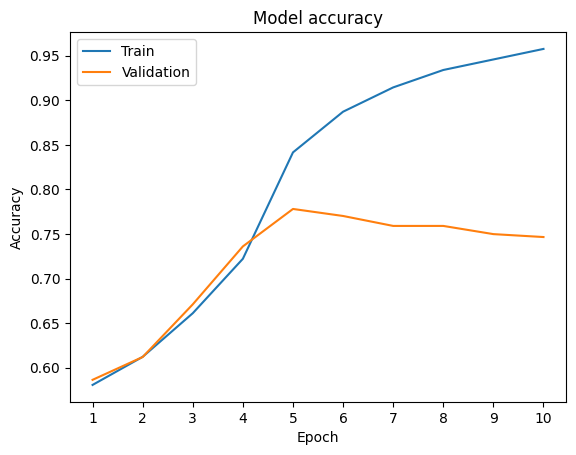

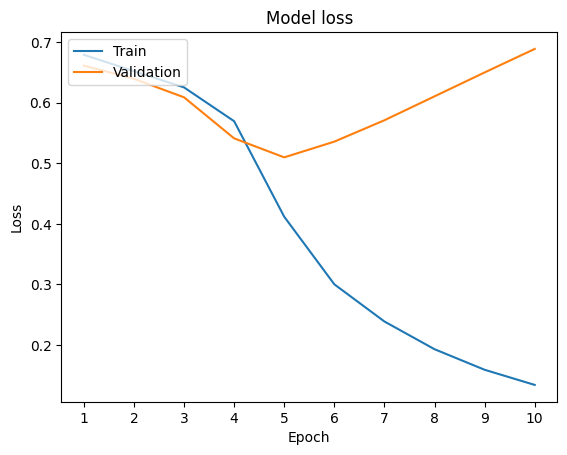

In [130]:
plot_training_history(history_bidirect)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Deep LSTM RNN Architecture</h3>
</div>

In [166]:
# Constructing the model
model_deep = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)), # max_len
    LSTM(128, return_sequences=True),  # First LSTM layer, returns sequences to feed into next LSTM layer
    LSTM(64, return_sequences=False),  # Second LSTM layer, does not need to return sequences
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Create a new Adam optimizer instance for this specific model
custom_adam = Adam(learning_rate=0.0001)

# Compile the model
model_deep.compile(optimizer=custom_adam, loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=True)

# Train the model
history_deep = model_deep.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=128, callbacks=[early_stop])

# Evaluate the model on the validation set
loss, accuracy = model_deep.evaluate(X_valid, y_valid)
print()
print("Validation accuracy:", accuracy)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.5707 - loss: 0.6867 - val_accuracy: 0.5745 - val_loss: 0.6557
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5938 - loss: 0.6562 - val_accuracy: 0.6238 - val_loss: 0.6423
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6540 - loss: 0.6386 - val_accuracy: 0.6743 - val_loss: 0.6213
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7212 - loss: 0.6018 - val_accuracy: 0.7413 - val_loss: 0.5587
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8161 - loss: 0.4642 - val_accuracy: 0.8017 - val_loss: 0.4466
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8720 - loss: 0.3225 - val_accuracy: 0.8004 - val_loss: 0.4500
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8922 - loss: 0.2755 - val_accuracy: 0.8096 - val_loss: 0.4693
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9095 - loss: 0.2400 - val_accuracy: 0.8076 - 

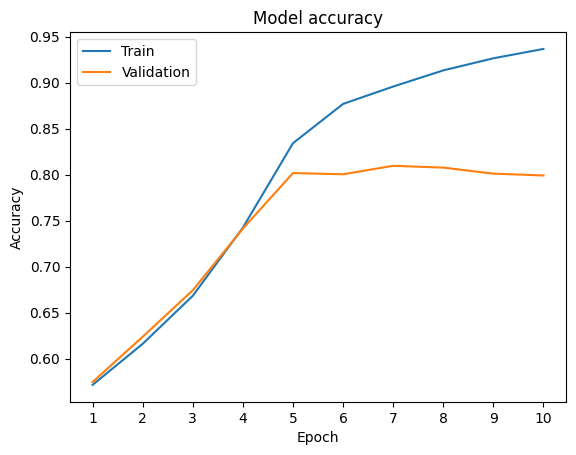

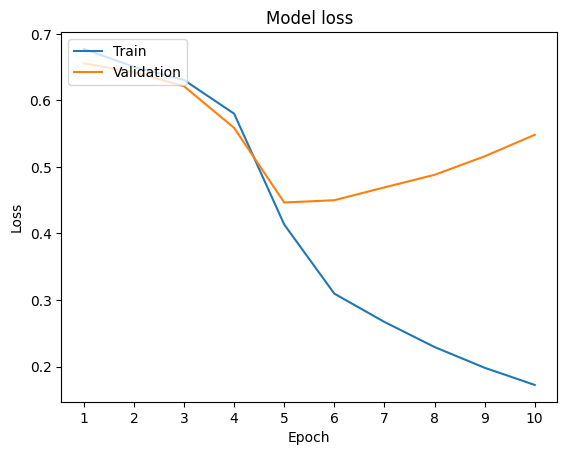

In [167]:
plot_training_history(history_deep)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Optional Utilities</h3>
</div>

In [148]:
# Plot models
#plot_model(model_vanilla, to_file='images/model_vanilla.png', show_shapes=True, show_layer_names=True)
#plot_model(model_LSTM, to_file='images/model_LSTM.png', show_shapes=True, show_layer_names=True)
#plot_model(model_bidirect, to_file='images/model_bidirect.png', show_shapes=True, show_layer_names=True)
#plot_model(model_deep, to_file='images/model_deep.png', show_shapes=True, show_layer_names=True)
#print("All images finished")

In [149]:
# Save models
#model_basic.save('models/model_vanilla.keras')
#model_deep.save('models/model_LSTM.keras')
#model_doubleConv.save('models/model_bidirect.keras')
#model_doubleDeep.save('models/model_deep.keras')

# Save history
#with open('history/model_vanilla.pkl', 'wb') as file:
#    pickle.dump(history_vanilla.history, file)

#with open('history/model_LSTM.pkl', 'wb') as file:
#    pickle.dump(history_LSTM.history, file)

#with open('history/model_bidirect.pkl', 'wb') as file:
#    pickle.dump(history_bidirect.history, file)

#with open('history/model_deep.pkl', 'wb') as file:
#    pickle.dump(history_deep.history, file)

In [150]:
# Load models
#model_basic = load_model('models/model_vanilla.keras')
#model_deep = load_model('models/model_LSTM.keras')
#model_doubleConv = load_model('models/model_bidirect.keras')
#model_doubleDeep = load_model('models/model_deep.keras')

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Conclusion</h3>
</div>

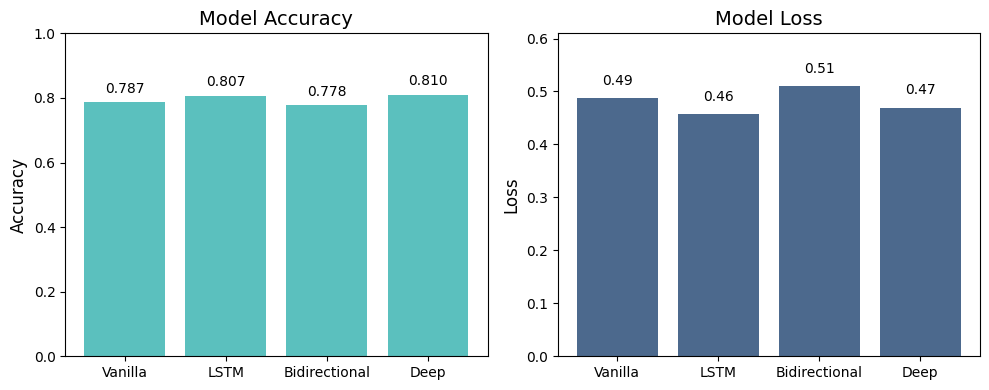

In [168]:
best = get_best_epoch_stats( ('Vanilla','LSTM', 'Bidirectional', 'Deep'), (history_vanilla, history_LSTM, history_bidirect, history_deep)  )
plot_model_metrics(*best)

As we can see from the figures above, the LSTM and Deep models outperforms the other two architectures. And out of the two LSTM and Deep, Deep had a slightly higher accuracy, while LSTM had a slightly lower model loss. Since the Deep model might have higher potential for improvement using regularization, since it is more complex, we will therefore continue using the Deep architecture for the rest of this project. We will in the next section explore if the Deep model can be further improved by changing optimizer and introducing regularization.

<div style="background-color: #0B132B; padding: 25px; border-radius: 8px; border: 2px solid #6FFFE9; margin-top: 0;">
    <h3 style="color: #5BC0BE; text-align: center; font-size: 26px; margin-top: 30; margin-bottom: 30">Results and Analysis</h3>
</div>

In this part of the assignment, we will try out different techniques to improve the training or performance. There are many methods one can use to improve the performance of a CNN - such as trying out different optimizers, adding L2 regularization to the neurons in the network, adding dropout layers and altering the number of neurons dropped by the dropout layers, trying out different learning rates - to mention a few.

However, the time to train a RNN can be fairly long, and we will not be able in this assignment to test all of these techniques. We will focus on testing the impact of **optimizers** and **L2 regularization**. More specifically, we will test whether another optimizer - RMSprop - can produce better results, and we will see if L2 regularization factor of 0.001 and 0.0001 can increase the accuracy. In all cases, we will use our top performing model, which is the Deep RNN model.

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Optimizers</h3>
</div>

In [152]:
# Constructing the model
model_deep_RMSprop = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)), # max_len
    LSTM(128, return_sequences=True),  # First LSTM layer, returns sequences to feed into next LSTM layer
    LSTM(64, return_sequences=False),  # Second LSTM layer, does not need to return sequences
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Create a new RMSprop optimizer instance for this specific model
custom_rmsprop = RMSprop(learning_rate=0.0001)

# Compile the model
model_deep_RMSprop.compile(optimizer=custom_rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=True)

# Train the model
history_deep_RMSprop = model_deep_RMSprop.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=128, callbacks=[early_stop])

# Evaluate the model on the validation set
loss, accuracy = model_deep_RMSprop.evaluate(X_valid, y_valid)
print()
print("Validation accuracy:", accuracy)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.5684 - loss: 0.6887 - val_accuracy: 0.5739 - val_loss: 0.6714
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5640 - loss: 0.6709 - val_accuracy: 0.5745 - val_loss: 0.6583
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5698 - loss: 0.6613 - val_accuracy: 0.5896 - val_loss: 0.6527
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5993 - loss: 0.6560 - val_accuracy: 0.6041 - val_loss: 0.6484
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6074 - loss: 0.6521 - val_accuracy: 0.6093 - val_loss: 0.6447
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6188 - loss: 0.6485 - val_accuracy: 0.6211 - val_loss: 0.6414
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6265 - loss: 0.6451 - val_accuracy: 0.6277 - val_loss: 0.6382
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6314 - loss: 0.6415 - val_accuracy: 0.6362 - v

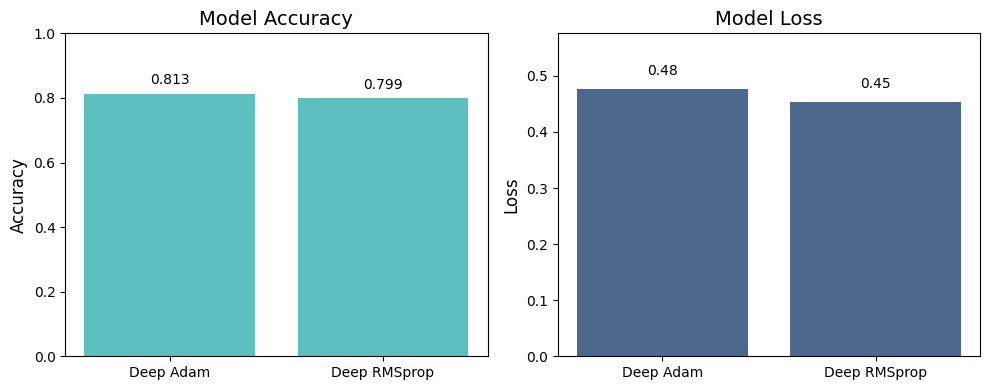

In [153]:
best = get_best_epoch_stats( ('Deep Adam', 'Deep RMSprop'), (history_deep, history_deep_RMSprop)  )
plot_model_metrics(*best)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">L2 Regularization</h3>
</div>

In [157]:
# Set the L2 regularization factor
l2_reg = 0.0001  # This is an example value and can be adjusted based on the needs

# Constructing the model with L2 regularization
model_deep_l2_0001 = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)), # max_len
    LSTM(128, return_sequences=True, kernel_regularizer=l2(l2_reg)),  # First LSTM layer with L2 regularization
    LSTM(64, return_sequences=False, kernel_regularizer=l2(l2_reg)),  # Second LSTM layer with L2 regularization
    Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),  # Dense layer with L2 regularization
    Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))  # Output layer with L2 regularization
])

# Create a new Adam optimizer instance for this specific model
custom_adam = Adam(learning_rate=0.0001)

# Compile the model
model_deep_l2_0001.compile(optimizer=custom_adam, loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=True)

# Train the model
history_deep_l2_0001 = model_deep_l2_0001.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=128, callbacks=[early_stop])

# Evaluate the model on the validation set
loss, accuracy = model_deep_l2_0001.evaluate(X_valid, y_valid)
print()
print("Validation accuracy:", accuracy)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.5800 - loss: 0.7299 - val_accuracy: 0.5824 - val_loss: 0.6949
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6034 - loss: 0.6932 - val_accuracy: 0.6389 - val_loss: 0.6756
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6739 - loss: 0.6683 - val_accuracy: 0.6855 - val_loss: 0.6456
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7439 - loss: 0.6101 - val_accuracy: 0.7846 - val_loss: 0.5233
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8354 - loss: 0.4389 - val_accuracy: 0.7938 - val_loss: 0.4805
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8691 - loss: 0.3490 - val_accuracy: 0.8102 - val_loss: 0.4930
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8904 - loss: 0.3040 - val_accuracy: 0.8168 - val_loss: 0.5033
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9099 - loss: 0.2643 - val_accuracy: 0.8063 - 

In [159]:
# Set the L2 regularization factor
l2_reg = 0.001  # This is an example value and can be adjusted based on the needs

# Constructing the model with L2 regularization
model_deep_l2_001 = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)), # max_len
    LSTM(128, return_sequences=True, kernel_regularizer=l2(l2_reg)),  # First LSTM layer with L2 regularization
    LSTM(64, return_sequences=False, kernel_regularizer=l2(l2_reg)),  # Second LSTM layer with L2 regularization
    Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),  # Dense layer with L2 regularization
    Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))  # Output layer with L2 regularization
])

# Create a new Adam optimizer instance for this specific model
custom_adam = Adam(learning_rate=0.0001)

# Compile the model
model_deep_l2_001.compile(optimizer=custom_adam, loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=True)

# Train the model
history_deep_l2_001 = model_deep_l2_001.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=128, callbacks=[early_stop])

# Evaluate the model on the validation set
loss, accuracy = model_deep_l2_001.evaluate(X_valid, y_valid)
print()
print("Validation accuracy:", accuracy)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.5620 - loss: 1.1174 - val_accuracy: 0.5739 - val_loss: 1.0544
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5759 - loss: 1.0437 - val_accuracy: 0.6205 - val_loss: 0.9997
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6491 - loss: 0.9898 - val_accuracy: 0.6500 - val_loss: 0.9516
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6984 - loss: 0.9343 - val_accuracy: 0.7111 - val_loss: 0.8920
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7875 - loss: 0.8350 - val_accuracy: 0.7892 - val_loss: 0.7441
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8511 - loss: 0.6448 - val_accuracy: 0.7912 - val_loss: 0.7054
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8779 - loss: 0.5551 - val_accuracy: 0.8056 - val_loss: 0.6975
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8930 - loss: 0.5025 - val_accuracy: 0.8070 - 

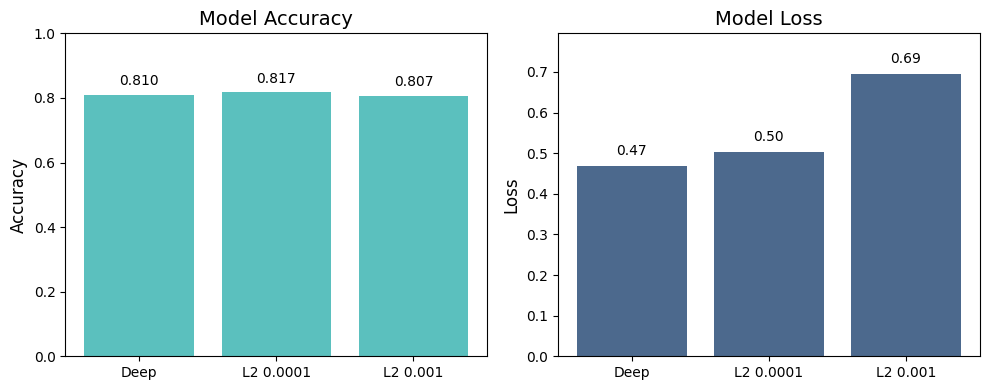

In [169]:
best = get_best_epoch_stats( ('Deep', 'L2 0.0001', 'L2 0.001'), (history_deep, history_deep_l2_0001, history_deep_l2_001)  )
plot_model_metrics(*best)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Optional Utilities</h3>
</div>

In [37]:
#model_deep_RMSprop.save('models/model_doubleDeep_RMSprop.keras')
#model_l2_001.save('models/model_deep_l2_001.keras')
#model_l2_0001.save('models/model_deep_l2_0001.keras')

# Save history
#with open('history/model_deep_RMSprop.pkl', 'wb') as file:
#    pickle.dump(history_deep_RMSprop.history, file)

#with open('history/model_deep_l2_001.pkl', 'wb') as file:
#    pickle.dump(history_deep_l2_001.history, file)

#with open('history/model_deep_l2_0001.pkl', 'wb') as file:
#    pickle.dump(history_deep_l2_0001.history, file)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Conclusion</h3>
</div>

In this part, we saw that ...

* Altering the optimizer to RMSprop did not improve the performance of the model. Our inital model, which was using Adam, had a slightly higher accuracy. However, RMSprop had a somewhat lower loss.
* L2 regularization did not improve the model either. It seems that the model did not overfit the data. This is the case even though we added only a small about of l2 regularization.
* Therefore we keep our best model, which is the Deep model.

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Prediction for Kaggle</h3>
</div>

In [184]:
def predict_text(df, tokenizer, model, max_len):
    """
    Uses a pre-trained RNN model to predict the target based on text data in a DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing the text data under 'text' column.
    tokenizer (Tokenizer): Pre-trained Keras Tokenizer used for training the model.
    model (tf.keras.Model): Pre-trained RNN model used for making predictions.
    max_len (int): Maximum length of the text sequences used for padding.

    Returns:
    pd.DataFrame: DataFrame with an additional column 'target' containing the predictions.
    """
    # Ensure text column is string type
    df['cleaned_text'] = df['cleaned_text'].astype(str)

    # Tokenize and pad the text data
    sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
    padded_sequences = pad_sequences(sequences, maxlen=max_len)

    # Predict using the RNN model
    predictions = model.predict(padded_sequences)

    # Convert predictions to binary (customize depending on your specific needs)
    df['target'] = (predictions > 0.5).astype(int)

    return df

In [195]:
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [201]:
df_test['cleaned_text'] = df_test['text'].apply(clean_text)
df_kaggle = predict_text(df_test, tokenizer, model_deep, max_len=15)
df_kaggle = df_kaggle[['id', 'target']]
df_kaggle

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [202]:
df_kaggle.to_csv('kaggle.csv', index=False)

<div style="background-color: #0B132B; padding: 15px; border-radius: 8px; border: 2px solid #6FFFE9; margin-top: 20px;">
    <h3 style="color: #5BC0BE; text-align: left; font-size: 22px; margin-top: 0;">Conclusion</h3>
</div>

In this assignment, we have seen that it is possible to build an RNN model that can distinguish between tweets that are reporting disasters and those that are not with a reasonably good accuracy. We saw that our top performing model managed to classify tweets with an accuracy of around 80%, according to the validaiton set. This assignment also led to some interesting findings concerning RNNs.  

* Architecture seem to be somewhat important compared to more conventional hyper parameter tuning and regularization.
* Both LSTM and bidirectional layers seem both to add positively to performance of the model.
* It is espacially challenging to try out many combinations of architecture and hyper parameter tunings on RNNs due to their large number of hyper parameters and possible architecutres long.